In [1]:
import os
os.environ["TF_CPP_MIN_LOG_LEVEL"] = "1"

In [2]:

from keras.models import load_model

pretrained_model = load_model("MobileNetV3Large.keras")

/Users/vpedos/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [3]:
# Import Data Science Libraries
import numpy as np
import pandas as pd
import random

# Import visualization libraries
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import cv2

# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers,models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.mobilenet_v3 import preprocess_input
# from tensorflow.keras.layers.experimental import preprocessing

from tensorflow.keras.applications import MobileNetV3Large
from keras.layers import Conv2D , MaxPool2D , Input , GlobalAveragePooling2D ,AveragePooling2D, Dense , Dropout ,Activation, Flatten , BatchNormalization

from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.callbacks import Callback, EarlyStopping, ModelCheckpoint
from tensorflow.keras import Model



In [5]:
TRAIN_DIR = 'plant_leave_disease_dataset/Pear/train'
TEST_DIR = 'plant_leave_disease_dataset/Pear/test'

train_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input,
    validation_split = 0.2
)

test_generator = ImageDataGenerator(
    preprocessing_function = preprocess_input
)

In [6]:
# Split the data into three categories.
train_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=8,
    shuffle=True,
    seed=42,
    subset='training'
)

val_images = train_generator.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=True,
    seed=42,
    subset='validation'
)

test_images = test_generator.flow_from_directory(
    TEST_DIR,
    target_size=(224, 224),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=2,
    shuffle=False
)

Found 1925 images belonging to 4 classes.
Found 480 images belonging to 4 classes.
Found 602 images belonging to 4 classes.


In [7]:
# Resize Layer
resize_and_rescale = keras.Sequential([
  layers.Resizing(224,224),
  layers.Rescaling(1./255),
])

# Setup data augmentation
data_augmentation = keras.Sequential([
  layers.RandomFlip("horizontal_and_vertical"),
  layers.RandomRotation(0.2),
  layers.RandomZoom(0.2),
  layers.RandomHeight(0.2),
  layers.RandomWidth(0.2),                       
], name="data_augmentation")

In [8]:
print(len(train_images))
print(len(val_images))

241
240


In [9]:
# Load the pretained model
pretrained_model.trainable = False


In [12]:
# Build model
inputs = pretrained_model.input
x = resize_and_rescale(inputs)
x = data_augmentation(x)

x = Dense(512, activation='relu')(pretrained_model.output)
x = Dropout(0.4)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.4)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)

outputs = Dense(4, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(
    optimizer = tf.keras.optimizers.Adam(0.0001),
    loss = tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy']
)

In [10]:
# Create checkpoint callback
checkpoint_path = "./Pear_CNN-Model/Checkpoint/model_pear.keras"
checkpoint_callback = ModelCheckpoint(checkpoint_path,
                                      save_weights_only=False,
                                      monitor="val_accuracy",
                                      save_best_only=True)


# Create callback to visualize data
tb_callback = tf.keras.callbacks.TensorBoard(log_dir='./Pear_CNN-Model/Graph', 
                                             histogram_freq=1, write_graph=True, 
                                             write_images=True, embeddings_freq=1)

In [13]:
# Train the model
history = model.fit(
    train_images,
    validation_data=val_images,
    epochs=60,
    callbacks=[
        EarlyStopping(patience = 5),
        tb_callback,
        checkpoint_callback,
    ]
)

Epoch 1/60


/Users/vpedos/Library/Python/3.9/lib/python/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


241/241 ━━━━━━━━━━━━━━━━━━━━ 117s 454ms/step - accuracy: 0.5974 - loss: 0.9679 - val_accuracy: 0.7271 - val_loss: 0.5695
Epoch 2/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 105s 425ms/step - accuracy: 0.7260 - loss: 0.6096 - val_accuracy: 0.7833 - val_loss: 0.4912
Epoch 3/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 105s 425ms/step - accuracy: 0.7541 - loss: 0.5421 - val_accuracy: 0.7958 - val_loss: 0.4441
Epoch 4/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 424ms/step - accuracy: 0.7987 - loss: 0.4665 - val_accuracy: 0.8062 - val_loss: 0.4283
Epoch 5/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 104s 424ms/step - accuracy: 0.8058 - loss: 0.4550 - val_accuracy: 0.8042 - val_loss: 0.4372
Epoch 6/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 103s 418ms/step - accuracy: 0.8287 - loss: 0.3977 - val_accuracy: 0.8021 - val_loss: 0.4269
Epoch 7/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 105s 427ms/step - accuracy: 0.8155 - loss: 0.4158 - val_accuracy: 0.8188 - val_loss: 0.4074
Epoch 8/60
241/241 ━━━━━━━━━━━━━━━━━━━━ 105s 426ms/step - accuracy: 0.8499 - loss: 0.34

In [13]:
# Show metrics
train_acc, train_loss = model.evaluate(train_images, verbose=0)
val_acc, val_loss = model.evaluate(val_images, verbose=0)
test_acc, test_loss = model.evaluate(test_images, verbose=0)
print("    Train Loss: {:.5f}".format(train_acc))
print("Train Accuracy: {:.2f}%".format(train_loss * 100))
print("    Valid Loss: {:.5f}".format(val_acc))
print("Valid Accuracy: {:.2f}%".format(val_loss * 100))
print("    Test Loss: {:.5f}".format(test_acc))
print("Test Accuracy: {:.2f}%".format(test_loss * 100))

    Train Loss: 0.26180
Train Accuracy: 89.35%
    Valid Loss: 0.39137
Valid Accuracy: 84.13%
    Test Loss: 0.36656
Test Accuracy: 84.05%


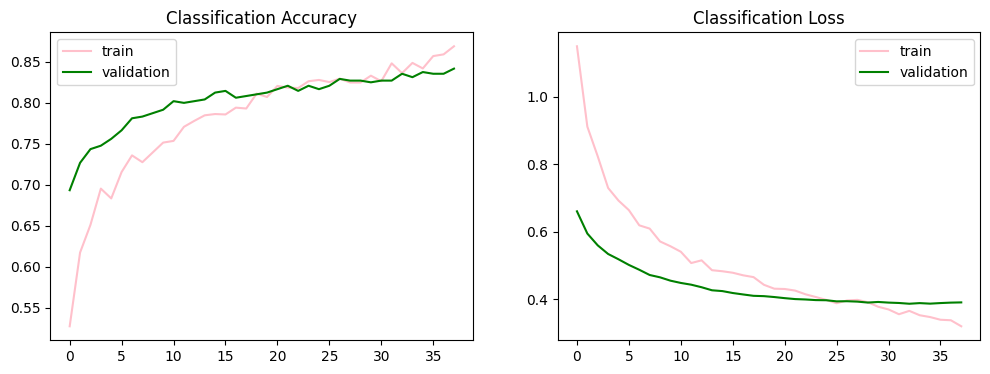

In [14]:
fig, (acc, loss) = plt.subplots(nrows = 1, ncols = 2)
fig.set_size_inches(12, 4)
acc.title.set_text('Classification Accuracy')
acc.plot(history.history['accuracy'], color = 'pink', label = 'train')
acc.plot(history.history['val_accuracy'], color = 'green', label = 'validation')
acc.legend(['train', 'validation'])

loss.title.set_text('Classification Loss')
loss.plot(history.history['loss'], color = 'pink', label = 'train')
loss.plot(history.history['val_loss'], color = 'green', label = 'validation')
loss.legend(['train', 'validation'])

plt.show()


In [15]:
# Create a HDF5 file 'my_model_mobilenet_v3.h5'
from keras.models import load_model

model.save('./Pear CNN-Model/pear_model_mobilenet_v3.keras')  